# PhishBuster - Spam Classification

## Business Understanding

### Background:
Email communication is a critical component of both personal and professional life, but it is also a common vector for cyberattacks. Unsafe emails, such as phishing attempts, spam, or emails containing malicious links or attachments, pose significant risks to users and organizations. Detecting and classifying emails as either safe or unsafe is crucial for protecting sensitive information, preventing financial loss, and ensuring overall cybersecurity.

### Problem Statement:
The problem is to develop a robust system that can automatically classify incoming emails into two categories: safe and unsafe. Safe emails are legitimate and pose no security threat, while unsafe emails include phishing attempts, spam, and those containing potentially harmful content such as malware or links to malicious websites.

### Objectives
- Accurate Classification: Maximize the precision and recall in detecting unsafe emails while minimizing false positives and false negatives.
- Timely Detection: Ensure the system processes emails efficiently, providing near-real-time classification.
- Scalability: The solution should handle large volumes of emails commonly encountered in corporate or enterprise environments.
- Explainability: The system should offer insights into why an email was classified as safe or unsafe to help users and administrators make informed decisions.
- Adaptability: The system should evolve and adapt to new and emerging threats in the email domain.

### Impact:
- Enhanced Security: An ML-driven system can provide more accurate detection of unsafe emails, reducing the likelihood of security breaches caused by phishing or malware.
- Operational Efficiency: Automating email classification saves time and resources for IT and security teams, allowing them to focus on higher-priority tasks.
- Reduced Financial Losses: Proactively identifying and stopping unsafe emails prevents costly cyber incidents, including ransomware attacks and data theft.
- Improved User Experience: Fewer false positives mean legitimate emails are not unnecessarily blocked, ensuring smoother communication for end users.
- Regulatory Compliance: Effective email filtering helps organizations comply with cybersecurity and data protection regulations (e.g., GDPR, HIPAA) by preventing unauthorized access to sensitive information.
- Competitive Advantage:Offering or leveraging state-of-the-art ML email protection can position a company as a leader in cybersecurity, building trust with clients and stakeholders.


Before we begin, we will import all required libraries. They are grouped by the stage they are first used.

In [89]:
# Import required libraries

# Data Collection and Understanding
import pandas as pd
import mailbox
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Data Splitting
from sklearn.model_selection import train_test_split

# Model Building
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# Model Evaluation and Tuning
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Model Export
import pickle

## Data Collection and Understanding

For our training data we used a collection of public databases containing labeled text data of safe and dangerous email messages. 

This consisted of:
1. Phishing_Email.csv (https://www.kaggle.com/datasets/subhajournal/phishingemails/data)
2. spam.csv (https://www.kaggle.com/datasets/muhammedtariq99/phishing-detection)
3. phishing_data_by_type.csv (https://www.kaggle.com/datasets/charlottehall/phishing-email-data-by-type)
4. emails-phising.mbox (https://github.com/diegoocampoh/MachineLearningPhishing)

In order to integrate our data we compiled the datasets into a single *csv* file with two columns
1. text: The text of the email
2. type: The type of email (safe/unsafe)

The *emails-phishing.mbox* dataset demanded additional consideration. Instead of partially processed structured data, it contained a raw collection of genuine phishing emails with everything intact. In order to integrate it into our data pipeline, we had to use the python *mailbox* library to transform the emails to our desired format.

It is advised to work off of the 

First we will deal with the three *csv* datasets. We need to read them into dataframes and keep the features that we are going to use. We will rename the features so that they are the same.

In [2]:
# Phishing_Email.csv
# Read, select features, rename features
df1 = pd.read_csv("./data/Phishing_Email.csv")
df1 = df1[['Email Text','Email Type']]
df1 = df1.rename(columns={'Email Text': 'text', 'Email Type': 'type'})

# spam.csv
# Read, select features, rename features
df2 = pd.read_csv('./data/spam.csv', encoding='latin-1')
df2 = df2[['v1','v2']]
df2 = df2.rename(columns={'v1': 'type', 'v2': 'text'})

# phishing_data_by_type.csv
# Read, select features, rename features
df3 = pd.read_csv('./data/phishing_data_by_type.csv')
df3 = df3[['Type', 'Text']]
df3 = df3.rename(columns={'Type': 'type', 'Text': 'text'})

To standardize the datasets, we need to replace the text categories with numbers.

In [3]:
# Replace sentiment categories with numbers
df1['type'] = df1['type'].replace({'Safe Email':0,'Phishing Email':1})
df2['type'] = df2['type'].replace({'ham':0, 'spam':1})
df3['type'] = df3['type'].replace({'False Positives ':0, 'Phishing':1, 'Fraud':1, 'Commercial Spam':1})

C:\Users\tytoa\AppData\Local\Temp\ipykernel_8448\2632987800.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['type'] = df1['type'].replace({'Safe Email':0,'Phishing Email':1})
C:\Users\tytoa\AppData\Local\Temp\ipykernel_8448\2632987800.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['type'] = df2['type'].replace({'ham':0, 'spam':1})
C:\Users\tytoa\AppData\Local\Temp\ipykernel_8448\2632987800.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the ol

Next we will dea lwith the *mbox* dataset. Because there are genuine phishing emails in the *mbox* file dataset, it will likely be quarantined by antivirus software. We ran this on a safe machine to extract the needed features and then saved the integrated dataframe to a *csv* file for future accesss.

In [4]:
#emails-phishing.mbox
# This loops through the individual messages in the mbox file
# It decodes the payload (body text) of each message
# It confirms that the message isn't empty and then parses the html into plain text
# Finally it produces a dataframe with the message texts
d = []
for message in mailbox.mbox('./data/emails-phishing.mbox'):
    payload = message.get_payload(decode=True)
    if (payload is None):
        cleantext = ""
    else:
        cleantext = BeautifulSoup(payload, "html.parser").text
        cleantext = cleantext.replace("\n", " ")
        cleantext = cleantext.replace("\t", " ")
    d.append({'text':cleantext})

df4 = pd.DataFrame(d)
df4['type'] = 1

Finally, we can combine the four dataframes into one and save the dataset for future access.

In [5]:
df = pd.concat([df1,df2,df3,df4], ignore_index=True)

# Line to save dataset if needed
#df.to_csv("data/integrated_data.csv")

### EDA

With our dataset integrated, we can perform some simple data analysis. Because this is a simple dataset with just two features this analysis doens't have much to explore. Once we perform some features NLP in the feature engineering stage we will perform some further analysis.

Loading the dataset and viewing it.

In [6]:
# Line to load dataset if needed
#df = pd.read_csv('./data/integrated_data.csv')
with pd.option_context('display.max_rows', None,):   print(df)

                                                    text  type
0      re : 6 . 1100 , disc : uniformitarianism , re ...     0
1      the other side of * galicismos * * galicismo *...     0
2      re : equistar deal tickets are you still avail...     0
3      \nHello I am your hot lil horny toy.\n    I am...     1
4      software at incredibly low prices ( 86 % lower...     1
5      global risk management operations sally congra...     0
6      On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...     0
7      entourage , stockmogul newsletter ralph velez ...     1
8      we owe you lots of money dear applicant , afte...     1
9      re : coastal deal - with exxon participation u...     0
10     make her beg you to give it to her everynight ...     1
11     URL: http://www.newsisfree.com/click/-5,830431...     0
12     begin forwarded text Date: Wed, 25 Sep 2002 13...     0
13     re : fyi - wellhead portfolio who is considere...     0
14     rmmla / ads * * * * * * * * papers solicited f..

In [50]:
print(df.text[3])


Hello I am your hot lil horny toy.
    I am the one you dream About,
    I am a very open minded person,
    Love to talk about and any subject.
    Fantasy is my way of life, 
    Ultimate in sex play.     Ummmmmmmmmmmmmm
     I am Wet and ready for you.     It is not your looks but your imagination that matters most,
     With My sexy voice I can make your dream come true...
  
     Hurry Up! call me let me Cummmmm for you..........................
TOLL-FREE:             1-877-451-TEEN (1-877-451-8336)For phone billing:     1-900-993-2582
-- 
_______________________________________________
Sign-up for your own FREE Personalized E-mail at Mail.com
http://www.mail.com/?sr=signup


Viewing the shape of the dataframe. There are 26 660 emails in the dataset.

In [72]:
df.shape

(26660, 2)

Viewing the proportion of safe and unsafe emails. We can see that there is some inbalance.

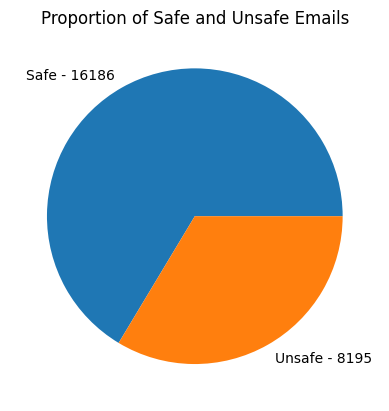

In [7]:
count = [int(df.type.value_counts()[0]), int(df.type.value_counts()[1])]
labels = [f'Safe - {int(df.type.value_counts()[0])}', f'Unsafe - {int(df.type.value_counts()[1])}']

fig, ax = plt.subplots()
ax.pie(count, labels=labels)
ax.set_title("Proportion of Safe and Unsafe Emails")
plt.show()

### Variables

Our dataset is now ready to be prepared. we will be performing some feature engineering on it with natural language processing to prepare the **text** feature **(the independent variable)** for input. The **type** feature **(our dependent variable)** is ready to go.

## Data Preperation

In data preperation we will wrangle data, engineer the features, perform EDA on the finalized features, and split the data for training and validation.

### Wrangle Data

Checking for missing values, we can see that there are 1088. We will drop them from the dataste.

In [9]:
# Check empty string values
print(df.where(df['text'] == '').count())

# Drop these values
df = df.drop(df[df['text'] == ''].index)

# Check empty string values
print(df.where(df['text'] == '').count())

text    0
type    0
dtype: int64
text    0
type    0
dtype: int64


There isn't much more we can do at this stage. Lets move on to feature engineering.

### Feature Engineering

This is the meat and potatoes of natural language processing. The algorithm we will be using for modeling - Naive Bayes - requires our input feature to be vectorized. In order to do this we must preprocess the text data and then transoform it to a numerical representation.

#### Text Preprocessing

The raw text needs to be preprocessed to remove unecessary information.

This involves:
- Removing capitalization
- Removing punctuation
- Removing stopwords (words which don't carry any information)
- Standardizing the words with a process like Lemmatization

We will define a function which does this and then use it to add a new column to our data frame with the preprocessed (cleaned) text. We need a list of stopwords which we will also download.

In [10]:
# Load stopword lists used in text preprocessing
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tytoa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Define a text pre-processing function
# Takes a string as input and returns a the preprocessed string
def preprocess_text(text):
    # Contruct a TextBlob object from the text
    blob = TextBlob(text)

    # Convert text to lowercase
    words = [word.lower() for word in blob.words]

    # Remove punctuation
    words = [word for word in words if word.isalpha()]
    
    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Perform text normalization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the words
    text = ' '.join(words)
    return text

With our function set up, we can apply it to the text feature on the dataframe.

In [12]:
# Apply preprocessing to text data
df['clean_text'] = df['text'].astype(str).apply(preprocess_text)

#### Text Vectorizing

To accurately represent the cleaned text with numbers, we can use Term Frequency-Inverse Document Frequency (TFIDF). This creates a matrix of numbers representing the importance of each word in each text.

In [13]:
# Fit and transform preprocessed text with TFIDF vetorization
tfidf = TfidfVectorizer()

# Fit the cleaned text with the TFIDF
vectors = tfidf.fit_transform(df.clean_text)
print(f"Emails: {vectors.shape[0]}, Words: {vectors.shape[1]}")

Emails: 24381, Words: 122791


### EDA

We can perform a some more analysis on our prepared data. 

We can visualize the cleaned text using a word cloud, splitting the dataset into safe and unsafe emails. We generate the wordclouds.

In [97]:
# Define a wordcloud object to generate plots 
safe_wordcloud = WordCloud(background_color='white',
                      max_words=200,
                      max_font_size=40,
                      scale=3,
                      random_state=1)
safe_wordcloud = WordCloud(background_color='white',
                      max_words=200,
                      max_font_size=40,
                      scale=3,
                      random_state=1)

# Combine all the safe texts to a single string
safe_string = ''
for s in df[df['type'] == 0].clean_text:
    safe_string = safe_string + s

# Combine all the unsafe texts to a single string
unsafe_string = ''
for s in df[df['type'] == 1].clean_text:
    unsafe_string = unsafe_string + s

# Generate the word clouds
safe_wordcloud.generate(safe_string)
unsafe_wordcloud.generate(unsafe_string)

And display them.

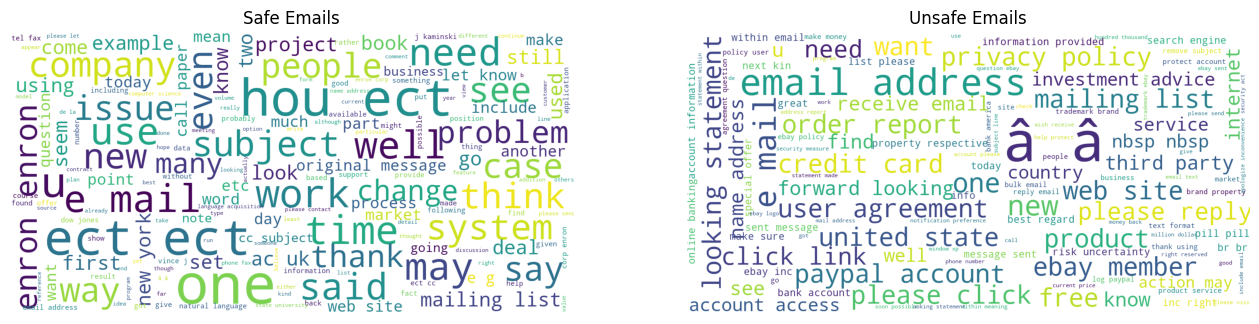

In [112]:
# Define plot
fig = plt.figure(1, figsize=(16, 16))

# Add safe_wordcloud to plot
ax = fig.add_subplot(1,2,1)
ax.imshow(safe_wordcloud)
ax.set_title('Safe Emails')
ax.axis('off')

# Add unsafe_wordcloud to plot
ax = fig.add_subplot(1,2,2)
ax.imshow(unsafe_wordcloud)
ax.set_title('Unsafe Emails')
ax.axis('off')

# Show plot
plt.show()

### Data Splitting

With our feature engineering and analysis complete, we can finish preparing the data by splitting it into a subset for training the model and for testing the model. As is standard, we reserve 80% of the data for training and 20% for testing.

In [14]:
# Define independent variables (X)
X = vectors

# Define dependent variables (y)
y = df['type']

# Perform 80:20 train:test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

## Model Building

We tested a variety of classifier algorithms on our dataset, and discovered that the best three options were Naive Bayes, Support Vector Machine, and Gradient Boosting Classifier. We will fit these models on the training data, and then make predictions on the testing data.

### Naive Bayes

In [115]:
# Create and fit a  Naive Bayes model using the vectorized training data
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [116]:
# Make predictions
y_pred_nb = nb_model.predict(X_test)

# Evaluate model
print("\nNaive Bayes Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_nb, average='weighted'))


Naive Bayes Model Performance:
Accuracy: 0.9300097751710655
Precision: 0.9322151671995125
Recall: 0.9300097751710655
F1 Score: 0.9288738448183345


### Support Vector Machine

In [117]:
# Create and fit a SVM model using the vectorized training data
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [118]:
# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate model
print("\nSupport Vector Machine Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_svm, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_svm, average='weighted'))


Support Vector Machine Model Performance:
Accuracy: 0.9591397849462365
Precision: 0.9590753914901676
Recall: 0.9591397849462365
F1 Score: 0.9590409434954021


### Gradient Boosting Classifier

In [119]:
# Create and fit a GBC model using the vectorized training data
gbc_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gbc_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

In [120]:
# Make predictions
y_pred_gbc = svm_model.predict(X_test)

# Evaluate model
print("\nSupport Vector Machine Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_gbc))
print("Precision:", precision_score(y_test, y_pred_gbc, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_gbc, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_gbc, average='weighted'))


Support Vector Machine Model Performance:
Accuracy: 0.9591397849462365
Precision: 0.9590753914901676
Recall: 0.9591397849462365
F1 Score: 0.9590409434954021


## Model Evaluation

For our purposes, we want to choose the model with the highest recall. This makes SVM and GBC our two best choices. We can view the exact outcomes of the predictions by confusion matrix heat maps. We can see that SVM and GBC had the same results.

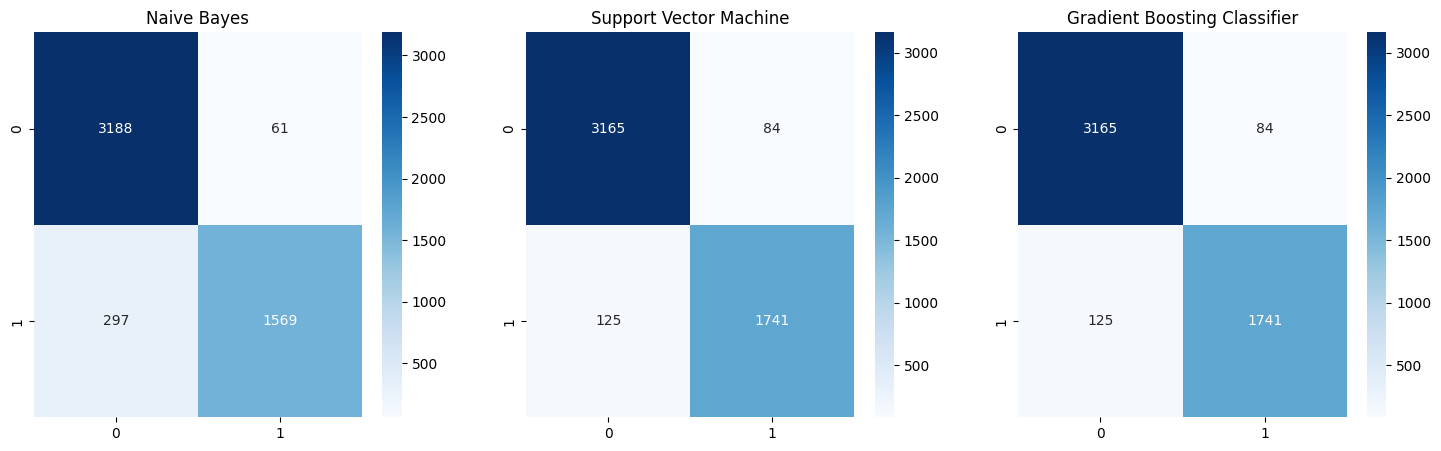

In [124]:
# Confusion Matrices for Advanced Models
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Naive Bayes')
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Support Vector Machine')
sns.heatmap(confusion_matrix(y_test, y_pred_gbc), annot=True, fmt='d', cmap='Blues', ax=ax[2])
ax[2].set_title('Gradient Boosting Classifier')
plt.show()

We will use the SVM as it is faster to fit and predict.

In [28]:
# Define ranges for randomized hyperparameter search
svc_params = {'C': [0.1, 1, 10, 100],
          'kernel': ['linear'],
          'gamma': [1, 0.01, 0.0001]}
          

# Perform randomized hyperparameter search
svc_grid = GridSearchCV(estimator=SVC(),
                        param_grid=svc_params,
                        scoring='recall',
                        cv=3,
                        verbose=3,)
svc_grid.fit(X_train, y_train)

# Display best model
print('Best hyper parameter:', svc_grid.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.756 total time= 2.4min
[CV 2/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.758 total time= 2.3min
[CV 3/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.731 total time=  58.1s
[CV 1/3] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.756 total time= 1.5min
[CV 2/3] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.758 total time= 1.3min
[CV 3/3] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.731 total time= 1.0min
[CV 1/3] END C=0.1, gamma=0.0001, kernel=linear;, score=0.756 total time= 1.2min
[CV 2/3] END C=0.1, gamma=0.0001, kernel=linear;, score=0.758 total time= 1.1min
[CV 3/3] END C=0.1, gamma=0.0001, kernel=linear;, score=0.731 total time= 1.2min
[CV 1/3] END .......C=1, gamma=1, kernel=linear;, score=0.917 total time=  42.3s
[CV 2/3] END .......C=1, gamma=1, kernel=linear;, score=0.914 total time=  41.7s
[CV 3/3] END .......C=1, gamma=1, kernel=linear;

## Save Model for Export

In order to deplay the model we need to serialize and save the TFIDF vectorizer and classifier models. 

In [106]:
# Serialize TFIDF Vectorization and SVM Classifier
with open('pickle/vectorizer.pkl', 'wb') as file: 
    pickle.dump(tfidf, file) 

# Serialize the model
with open('pickle/classifier.pkl', 'wb') as file: 
    pickle.dump(svc_grid, file) 